In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import time
import warnings
warnings.filterwarnings('ignore')

## Считывание данных из csv файла

In [117]:
n = 22

data = pd.read_csv('/home/bobbi/Рабочий стол/Gasnikov/trips.csv', header=None)

d = np.zeros((n, n))
T = 240 * np.ones((n, n))

for line in data.values:
    i = int(line[0]) - 1
    j = int(line[1]) - 1
    
    d[i, j] = float(line[2])
    T[i, j], T[j, i] = float(line[3]), float(line[3])
    
L = d.sum(axis=1).reshape((n,1))
W = d.sum(axis=0).reshape((n,1))

FileNotFoundError: File b'/home/bobbi/\xd0\xa0\xd0\xb0\xd0\xb1\xd0\xbe\xd1\x87\xd0\xb8\xd0\xb9 \xd1\x81\xd1\x82\xd0\xbe\xd0\xbb/Gasnikov/trips.csv' does not exist

## Функции для спуска по параболам

In [34]:
def parab_descent(x0, f):
    
    res = np.inf
    f0 = x0[1]
    dx = 1.
    i = 0
    
    while res > 1e-6:
        i += 1
        
        x = descent_step(x0, dx, f)
        res = abs(x[0] - x0[0])
        dx = dx / 2
        x0 = np.copy(x)
    print('Parab descent results:', 'iter =', i, 'sol =', x0[0], 'residual =', x0[1])
        
    return x0
        

def parab(x, a, b, c):
    return a * x * x + b * x + c

def descent_step(x, dx, f):
    
    xm1 = np.array([x[0] - dx, f(x[0] - dx)])
    xp1 = np.array([x[0] + dx, f(x[0] + dx)])
    
    x_array = [xm1[0], x[0], xp1[0]]
    y_array = [xm1[1], x[1], xp1[1]]
    
    a, b, c = parab_coeffs(xm1, x, xp1)
    
    x0 = np.array([-b / 2 / a, parab(-b / 2 / a, a, b, c)])
    
    xs = np.linspace(xm1[0], xp1[0], 10)
    ys = [parab(xi, a, b, c) for xi in xs]
    
    if a < 0:
        if ys[0] < ys[-1]:
            return xm1
        else:
            return xp1
    else:
        if x0[0] < 0:
        
            minimum = min(xm1[1], xp1[1])
        
            if xm1[1] == minimum:
                return xm1
            else:
                return xp1
            
        else:
            return np.array([x0[0], f(x0[0])])
        
    

def parab_coeffs(x1, x2, x3):
    
    a = ((x3[1] - (x3[0] * (x2[1] - x1[1]) + x2[0] * x1[1] - x1[0] * x2[1]) / (x2[0] - x1[0])) /
         (x3[0] * (x3[0] - x1[0] - x2[0]) + x1[0] * x2[0]))
    
    b = (x2[1] - x1[1]) / (x2[0] - x1[0]) - a * (x1[0] +x2[0])
    
    c = (x2[0] * x1[1] - x1[0] * x2[1]) / (x2[0] - x1[0]) + a * x1[0] * x2[1]
    
    return a, b, c

## Sinkhorn's algorithm

In [35]:
def sinkhorn(A, B, W, L, f):
    A = (1.0 / ((B.T * W.T * f).sum(axis=1))).reshape((n,1))
    B = (1.0 / ((A * L * f).sum(axis=0))).T.reshape((n,1))
    return A, B

In [36]:
def calculate_for_alpha(alpha, iter_num, p=False):

    A = np.random.random((n,1))
    B = np.random.random((n,1))

    dA = []
    dB = []
    f_a = np.exp(-alpha * T)

    for i in range(iter_num):
        
        A_n, B_n = sinkhorn(A,B,W,L,f_a)
        
        dA_n =  np.linalg.norm(A - A_n) / np.linalg.norm(A)
        dB_n = np.linalg.norm(B - B_n) / np.linalg.norm(B)
        
        dA.append(dA_n)
        dB.append(dB_n)
        
        A, B = A_n, B_n
    
    if p:
        plt.subplot(2, 1, 1)
        plt.scatter(range(20, iter_num), dA[20:], s = 1)
        plt.ylabel('|dA|/|A|')

        plt.subplot(2, 1, 2)
        plt.scatter(range(20, iter_num), dB[20:], s = 1)
        plt.ylabel('|dB|/|B|')
        plt.xlabel('iter #')

        plt.show()

    return np.dot((A * L) , (B * W).T) * f_a

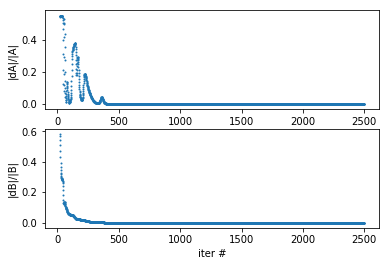

34223.4470114


In [37]:
alpha = 1.
r = calculate_for_alpha(alpha, 2500, True)
print(np.sum((r - d) * (r - d)))

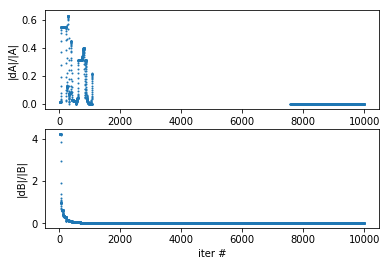

In [38]:
r = calculate_for_alpha(5, 10000, True)

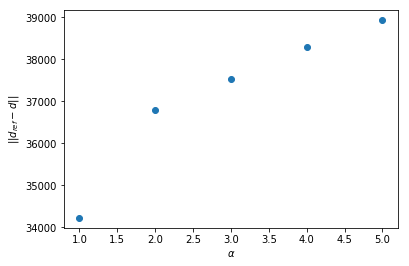

In [39]:
res = []
alphas = range(1,9)
for alpha in alphas:
    r = calculate_for_alpha(alpha, 2500)
    res.append(np.sum((r - d)*(r - d)))

plt.scatter(alphas, res)
plt.ylabel(r'$||d_{ref} - d||$')
plt.xlabel(r'$\alpha$')
plt.show()

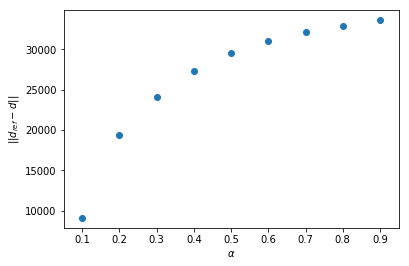

In [40]:
### Окно значений alpha: 0.1-1.0####
res = []
alphas = np.arange(0.1,1.0,0.1)
for alpha in alphas:
    r = calculate_for_alpha(alpha, 2500)
    res.append(np.sum((r - d)*(r - d)))

plt.ylabel(r'$||d_{ref} - d||$')
plt.xlabel(r'$\alpha$')
plt.scatter(alphas, res)
plt.show()

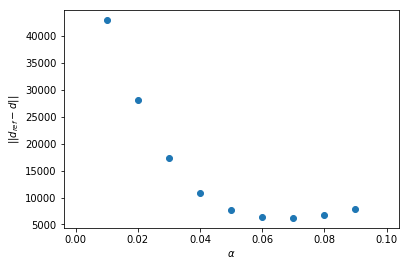

In [41]:
### Окно значений alpha: 0.01-0.1####
res = []
alphas = np.arange(0.01,0.1,0.01)
for alpha in alphas:
    r = calculate_for_alpha(alpha, 2500)
    res.append(np.sum((r - d)*(r - d)))

plt.scatter(alphas, res)
plt.ylabel(r'$||d_{ref} - d||$')
plt.xlabel(r'$\alpha$')
plt.show()

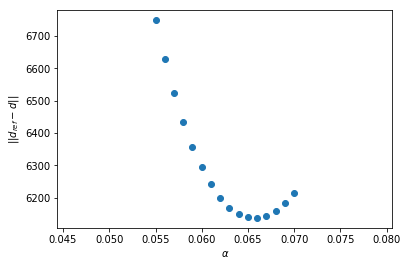

In [42]:
res = []
alphas = np.arange(0.055,0.07,0.001)
for alpha in alphas:
    r = calculate_for_alpha(alpha, 2500)
    res.append(np.sum((r - d)*(r - d)))

plt.ylabel(r'$||d_{ref} - d||$')
plt.xlabel(r'$\alpha$')
plt.scatter(alphas, res)
plt.show()

In [43]:
alpha = 2.
a0 = np.array([alpha, residual3(alpha)])
sol = parab_descent(a0, residual3)
print('Scipy minimization with Sinkhorn results:\n', opt.minimize_scalar(residual3))

Parab descent results: iter = 14 sol = 0.0656570343144 residual = 6136.79127658
Scipy minimization with Sinkhorn results:
      fun: 6136.7912764949342
    nfev: 19
     nit: 18
 success: True
       x: 0.065656897290650357


## Невязки могут считаться 3 способами

In [21]:
#Невязка при расчете с помощью AAM v.1 (не работает)
def residual1(alpha, eps=1e-2, A=2.):
    acc = A * eps / 2.
    r = accel_alt_method(alpha, acc)
    lmda1 = eta[0:n]
    lmda2 = eta[n:2 * n]
    r = B(alpha, eta)
    return np.sum((r - d)*(r - d))

#Невязка при расчете с помощью AAM v.2
def residual2(alpha, eps=1e-2, iter_num=5000):
    r = AARBCD(L, W, alpha, eps, iter_num)
    return np.sum((r - d)*(r - d))

In [22]:
#Невязка при расчете с помощью алгоритма Синхорна
def residual3(alpha):
    r = calculate_for_alpha(alpha, 2500)
    return np.sum((r - d)*(r - d))

## Accelerated alternating method v.1

In [29]:
def accel_alt_method(alpha, accuracy):
#     alpha = (accuracy / 3 / np.log(n))**(-1)
    
    x = np.random.random(n * 2)
#     Lipsh = 2 * abs(phi(alpha, x) / np.linalg.norm(grad_phi(alpha, x, 1))**2
    Lipsh = 10.
    
    while True:
        Lipsh, eta = PDAAM(alpha, Lipsh)
        if phi(alpha, eta) <= accuracy / 3.:
            return eta

In [30]:
def PDAAM(alpha, Lipsh0):
    
    A, a = 0, 0
    eta, xi, lmda = np.zeros(2 * n), np.zeros(2 * n), np.zeros(2 * n)

    Lipsh = Lipsh0 / 2
    while True:
        a = 1 / 2 / Lipsh + (1 / 4 / Lipsh**2 + a**2 * Lipsh0 / Lipsh)**0.5
        tau = 1 / a / Lipsh
        lmda = tau * xi + (1 - tau) * eta
#         print('!', a, L, tau, xi, eta)
        if (np.linalg.norm(grad_phi(alpha, lmda, 1)))**2 > (np.linalg.norm(grad_phi(alpha, lmda, 2)))**2:
            i = 1
        else:
            i = 2
            
#         print('lmda', lmda)
#         print('eta', eta)
        eta = min_phi(alpha, lmda, i)
#         print("?", eta.shape, min_phi(alpha, lmda, i))
#         print('xixi', grad_phi(alpha, lmda, i).shape)
        xi = xi - a * grad_phi(alpha, lmda, i)

        if phi(alpha, eta) <= phi(alpha, lmda) - np.linalg.norm(grad_phi(alpha, lmda, i))**2 / 2 / Lipsh:
            break
        
        Lipsh = 2 * Lipsh
    
    return Lipsh, eta
        

In [31]:
def min_phi(alpha, x, i):
    x1 = x[0:n]
    x2 = x[n:2 * n]
    
    if i == 1:
        h = (np.log(L.reshape(n,)) - np.log(np.dot(B(alpha, x), np.ones(n))), x2)
        x1 = x1 + h
        x = np.concatenate((x1, x2))
#         print('?1', x.shape)
        return x
    if i == 2:
        h = np.log(W.reshape(n,)) - np.log(np.dot(B(alpha, x).T, np.ones(n)))
        x2 = x2 + h
        x = np.concatenate((x1, x2))
#         print('?2', x.shape)
        return x
    
def B(alpha, x):
    x1 = x[0:n]
    x2 = x[n:2 * n]
    
    D1 = np.diag(np.exp(x1))
    K = np.exp(-alpha * C)
    D2 = np.diag(np.exp(x2))
#     print(D1.shape, D2.shape, x2)
    
    return np.dot(D1, np.dot(K, D2))
    
def grad_phi(alpha, x, i):
    
    x1 = x[0:n]
    x2 = x[n:2 * n]
    I = np.ones(n)
    D1 = np.diag(np.exp(x1))
    K = np.exp(-alpha * C)
#     print(C.shape)
    D2 = np.diag(np.exp(x2))
#     print('KD2', K.shape, D2.shape)
    
    KD2 = np.dot(np.dot(K, D2), I)
    
    D1K = np.dot(I.T, np.dot(D1, K))
    
    if i == 1:
        x1 = 1 / alpha * np.dot(np.dot(I.T, np.diag(x1 * np.exp(x1))), KD2) - L.reshape((n,))
        return np.concatenate((x1, np.zeros(n)))
    if i == 2:
        x2 = 1 / alpha * np.dot(D1K, np.dot(np.diag(x2 * np.exp(x2)), I)) - W.reshape((n,))
        return np.concatenate((np.zeros(n), x2))
    
def phi(alpha, x):
    x1 = x[0:n]
    x2 = x[n:2 * n]
    
    return 1 / alpha * np.dot(np.dot(np.ones(n), B(alpha, x)), np.ones(n)) - np.dot(x1, L) - np.dot(x2, W) - 1

## Accelerated alternating method v.2

In [111]:
def AARBCD(r, c, alpha, epsilon, iter_num):
    
    gamma = 1 / alpha
    maxT = np.max(T)
    
    maxIter = iter_num #5000
    X = np.zeros((n, n))
    
    phi_x = 0
    phi_y = 0  
    grad_phi1 = np.zeros((2 * n, 1))
    grad_phi2 = np.zeros((2 * n, 1))
    
    gap = 0
    
    A = 0
    a = 0
    x = np.zeros((2 * n, 1)) #lambda
    y = np.zeros((2 * n, 1)) #eta
    z = np.zeros((2 * n, 1)) #zeta
    
    r0 = r #L
    c0 = c #W
    
    eps = epsilon / 8 / maxT
    
    r = (1 - eps/8) * (r + np.array([eps/n/(8 - eps)] * n).reshape((n, 1)))
    c = (1 - eps/8) * (c + np.array([eps/n/(8 - eps)] * n).reshape((n, 1)))
    
    r = r / np.sum(r)
    c = c / np.sum(c)
    
    for k in range(maxIter):
        flag = True
        j = 0
        while flag == True:
            a_t = 2**((1 - 1*j)*a)
            A_t = A + a_t
            tau = a_t / A_t
            
            x_t = tau * z + (1 - tau) * y
            
            lmbda = x_t[0 : n, 0] #u
            mu = x_t[n : 2 * n, 0] #v
            
            T_new = -T / gamma + np.dot(lmbda.reshape((n, 1)), np.ones((1, n))) + np.dot(np.ones((n, 1)), mu.T.reshape((1, n)))
            X_lmbda = np.exp(T_new)
            
            x_interm_t = np.zeros((2 * n, 1))
            
            x_interm_t[0:n, 0] = np.log(r.reshape((n,)) * np.sum(X_lmbda, axis=1)**(-1)) + lmbda
            x_interm_t[n:2 * n, 0] = mu
            
            lmbda = x_interm_t[0:n, 0]
            T_new = -T / gamma + np.dot(lmbda.reshape((n, 1)), np.ones((1, n))) + np.dot(np.ones((n, 1)), mu.T.reshape((1, n)))
            X_lmbda = np.exp(T_new)
            sum_X = np.sum(np.sum(X_lmbda))
            
            grad_phi2 = np.zeros((2 * n, 1))
            # Производная \phi по "второму блоку"
            grad_phi2[n:2 * n, 0] = np.sum(X_lmbda, axis=0) - c.T
            phi_x_t = sum_X - np.dot(lmbda.T, r) - np.dot(mu.T, c)
            
#             # Производная \phi по "первому блоку"
#             X_1 = np.dot(np.diag(lmbda), np.exp(T_new))
#             grad_phi1 = np.zeros((2 * n, 1))
#             grad_phi1[n:2 * n, 0] = np.sum(X_1, axis=0) - r.T
            
#             # Производная \phi по "второму блоку"
#             X_2 = np.dot(np.exp(T_new), np.diag(mu))
#             grad_phi2 = np.zeros((2 * n, 1))
#             grad_phi2[n:2 * n, 0] = np.sum(X_2, axis=0) - c.T
            
#             # argmin \phi для первого блока
#             x_interm_t = np.zeros((2 * n, 1))
#             x_interm_t[0:n, 0] = np.log(r.reshape((n,)) * np.sum(X_lmbda, axis=1)**(-1)) + lmbda
#             x_interm_t[n:2 * n, 0] = mu

#             lmbda = x_interm_t[0:n, 0]
#             mu = x_interm_t[n:2 * n, 0]
#             T_new = -T / gamma + np.dot(lmbda.reshape((n, 1)), np.ones((1, n))) + np.dot(np.ones((n, 1)), mu.T.reshape((1, n)))
#             X_lmbda = np.exp(T_new)
#             sum_X = np.sum(np.sum(X_lmbda))
#             phi_x_t = sum_X - np.dot(lmbda.T, r) - np.dot(mu.T, c)

            # argmin \phi для второго блока
            y_t = np.zeros((2 * n, 1))
            y_t[0:n, 0] = lmbda
            y_t[n:2 * n, 0] = mu + np.log(c.reshape((n,)) * (np.sum(X_lmbda, axis=0).T)**(-1))

            lmbda = y_t[0:n, 0]
            mu = y_t[n:2 * n, 0]
            T_new = -T / gamma + np.dot(lmbda.reshape((n, 1)), np.ones((1, n))) + np.dot(np.ones((n, 1)), mu.T.reshape((1, n)))
            Z = np.exp(T_new)
            sum_Y = np.sum(np.sum(Z))
            phi_y_t = sum_Y - np.dot(lmbda.T, r) - np.dot(mu.T, c)
            
            z_t = z - a_t * grad_phi2
            upper = A_t * phi_y_t - A * phi_y
            lower = a_t * phi_x_t + a_t * np.dot(grad_phi2.T, (z_t - x_interm_t)) + (a_t**2 / 2) * np.linalg.norm(grad_phi2)**2
            l = upper - lower
            
            if l <= 0:
                flag = False
                x = x_t
                y = y_t
                z = z_t
                phi_y = phi_y_t
                
                A = A_t
                a = a_t
                
                X = tau * X_lmbda + (1 - tau) * X
            
            j = j + 1
        
        X_hat = X_on_U_projection(X, r, c)
        error_constr = np.sum(np.sum(np.multiply(T, (X_hat - X))))
        
        if (error_constr < epsilon / 6) and (k > 10):
            efunc = abs(np.sum(np.sum(np.multiply(T, X))) + gamma * np.sum(np.sum(np.multiply(np.log(X), X))) + gamma * phi_y_t - gamma)
            
            if efunc < epsilon / 6.:
                break
#     print(k)
    return X_hat


def X_on_U_projection(X, r, c):
    
    I = np.ones((n, 1))
    
    x = r * (np.dot(X, I))**(-1)
    x = np.vectorize(lambda t: min(t, 1))(x)
    F1 = X.T * x[:, None].T
    F1 = F1.reshape((n,n,))
    
    y = c.reshape((1, n)) * (np.dot(F1.T, I))**(-1)
    y = np.vectorize(lambda t: min(t, 1))(y)
    F2 = np.dot(F1, y.T)
    
    err_r = r - np.dot(F2, I)
    err_c = c - np.dot(F2, I)
    
    X = F2 + np.dot(err_r, err_c.T) / np.linalg.norm(err_r, 1)
    
    return X

## Результаты расчета невязки $||d_{ref} - d||$ с помощью AAM

In [95]:
alphas = np.arange(1, 10, 1)
res1 = []
for a in alphas:
    res1.append(residual2(a, iter_num=5000))

4999
4999
4999
4999
4999
4999
4999
4999
4999


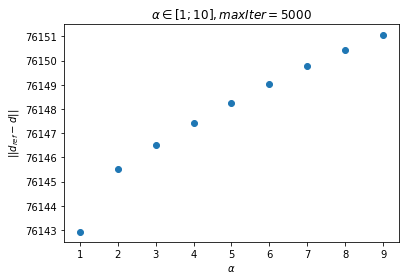

In [96]:
plt.scatter(np.arange(1, 10, 1), res1)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$||d_{ref} - d||$')
plt.title(r'$\alpha \in [1; 10], maxIter=5000$')
plt.show()

In [97]:
alphas = np.arange(0.01, 0.1, 0.01)
res0 = []
for a in alphas:
    res0.append(residual2(a))

4999
4999
4999
4999
4999
4999
4999
4999
4999


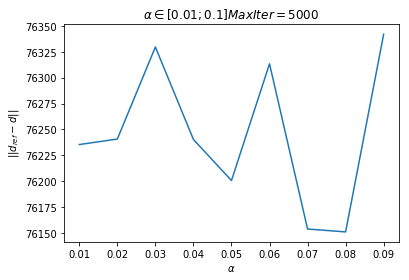

In [98]:
plt.plot(np.arange(0.01, 0.1, 0.01), res0)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$||d_{ref} - d||$')
plt.title(r'$\alpha \in [0.01; 0.1] MaxIter=5000$')
plt.show()

In [99]:
alphas = np.arange(0.055,0.07,0.001)
res2 = []
for a in alphas:
    res2.append(residual2(a))

4999
4999
4999
4999
4999
4999
4999
4999
4999
4999
4999
4999
4999
4999
4999
4999


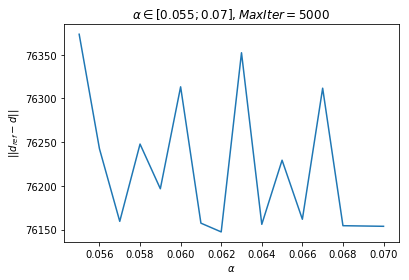

In [113]:
plt.plot(np.arange(0.055,0.07,0.001), res2)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$||d_{ref} - d||$')
plt.title(r'$\alpha \in [0.055; 0.07],MaxIter=5000$')
plt.show()

## Уменьшим кол-во итераций для AAM

In [101]:
res4 = []
alphas = np.arange(0.01, 0.1, 0.01)
for a in alphas:
    res4.append(residual2(a, iter_num=1000))

999
999
999
999
999
999
999
999
999


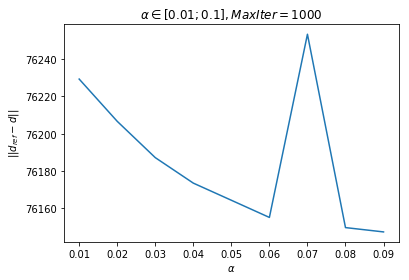

In [102]:
plt.plot(np.arange(0.01, 0.1, 0.01), res4)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$||d_{ref} - d||$')
plt.title(r'$\alpha \in [0.01; 0.1], MaxIter=1000$')
plt.show()

In [103]:
res5 = []
alphas = np.arange(0.05, 0.15, 0.01)
for a in alphas:
    res5.append(residual2(a, iter_num=1000))

999
999
999
999
999
999
999
999
999
999


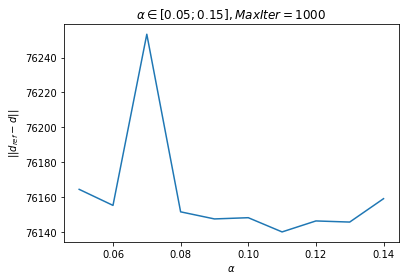

In [104]:
plt.plot(np.arange(0.05, 0.15, 0.01), res5)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$||d_{ref} - d||$')
plt.title(r'$\alpha \in [0.05; 0.15], MaxIter=1000$')
plt.show()

In [105]:
res6 = []
alphas = np.arange(0.05, 0.15, 0.01)
for a in alphas:
    res6.append(residual2(a, iter_num=2500))

2499
2499
2499
2499
2499
2499
2499
2499
2499
2499


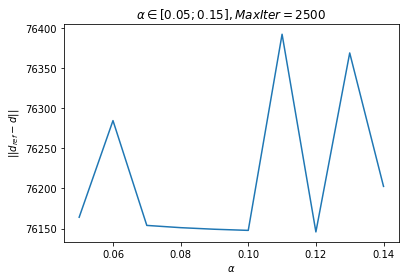

In [106]:
plt.plot(np.arange(0.05, 0.15, 0.01), res6)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$||d_{ref} - d||$')
plt.title(r'$\alpha \in [0.05; 0.15], MaxIter=2500$')
plt.show()

In [107]:
alphas = np.arange(0.055,0.07,0.001)
res7 = []
for a in alphas:
    res7.append(residual2(a, iter_num=20000))

19999
19999
19999
19999
19999
19999
19999
19999
19999
19999
19999
19999
19999
19999
19999
19999


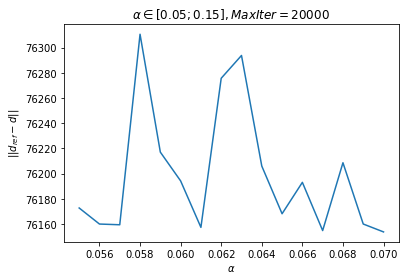

In [108]:
plt.plot(np.arange(0.055,0.07,0.001), res7)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$||d_{ref} - d||$')
plt.title(r'$\alpha \in [0.05; 0.15], MaxIter=20000$')
plt.show()

## Поиск минимума $||d_{ref} - d||$ по $\alpha$ с помощью алгоритма Синхорна и время расчета для одного $\alpha$

In [109]:
alpha = 2.
timer = time.time()
a0 = np.array([alpha, residual3(alpha)])
print('Time for Sinkhorn:', time.time() - timer)
timer = time.time()
sol = parab_descent(a0, residual3)
print('Time for parab descent with AAM:', time.time() - timer)
timer = time.time()
print(opt.minimize_scalar(residual3))
print('Time for scipy minimization:', time.time() - timer)

Time for Sinkhorn: 0.47815370559692383
Parab descent results: iter = 14 sol = 0.0656570343144 residual = 6136.79127658
Time for parab descent with AAM: 16.57801342010498
     fun: 6136.7912764949342
    nfev: 19
     nit: 18
 success: True
       x: 0.06565689729065953
Time for scipy minimization: 10.258602619171143


## Время расчета для одного $\alpha$

In [116]:
alpha = 2.
timer = time.time()
a0 = np.array([alpha, residual2(alpha, iter_num=1000)])
print('Time for AAM with 1000 iter:', time.time() - timer)
a0 = np.array([alpha, residual2(alpha, iter_num=2500)])
print('Time for AAM with 2500 iter:', time.time() - timer)
a0 = np.array([alpha, residual2(alpha, iter_num=5000)])
print('Time for AAM with 5000 iter:', time.time() - timer)
# timer = time.time()
# sol = parab_descent(a0, residual2)
# print('Time for parab descent with AAM:', time.time() - timer)
# timer = time.time()
# print(opt.minimize_scalar(residual2))
# print('Time for scipy minimization:', time.time() - timer)

Time for AAM with 1000 iter: 1.7069377899169922
Time for AAM with 2500 iter: 5.824855804443359
Time for AAM with 5000 iter: 14.100573062896729
